# Dataset Creation using Florence2

### Students:
  - Idan Dunsky, 319070595
  - Yaniv Kaveh-Shtul, 206768004



## TL;DR

This project involves creating a dataset of images categorized as either 'person' or 'pet.' We will clean the data, apply the Florence2 model for object detection, and filter results to focus on relevant objects. Finally, we will organize 800 images per class—640 for training and 160 for validation—to build and evaluate a robust computer vision model.

# Imports and Installations

In [13]:
!pip install flash_attn timm
!pip install -q kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 65.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 88.2 MB/s eta 0:00:00
  Created wheel for flash_attn: filename=flash_attn-2.6.3-cp310-cp310-linux_x86_64.whl size=187309225 sha256=237ef9c6157db394e1ddde4ba609a21ebb98382377a27041edc09318801a6f24
  Stored in directory: /root/.cache/pip/wheels/7e/e3/c3/89c7a2f3c4adc07cd1c675f8bb7b9ad4d18f64a72bccdfe826
Successfully built flash_attn


In [14]:
import requests
import copy
import torch
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
import os

from google.colab import drive
from PIL import Image
from transformers import AutoProcessor, AutoModelForCausalLM
from google.colab import files
from torch.utils.data import Dataset
from tqdm import tqdm

%matplotlib inline

random.seed(42)

# Flickr Image Dataset

In [52]:
drive.mount('/content/drive')
BASE_PATH = '/content/drive/MyDrive/SoftwareEngDegree/Computer_Vision/Pet_and_People_Rec_Project/'

# Define paths for train and validation
IMAGES_PATH = os.path.join(BASE_PATH, 'flickr30k_filtered_images')
TRAIN_PATH = os.path.join(BASE_PATH, 'dataset/train/')
VAL_PATH = os.path.join(BASE_PATH, 'dataset/val/')
TRAIN_IMAGES_PATH = os.path.join(TRAIN_PATH, 'images/')
VAL_IMAGES_PATH = os.path.join(VAL_PATH, 'images/')
TRAIN_LABELS_PATH = os.path.join(TRAIN_PATH, 'labels/')
VAL_LABELS_PATH = os.path.join(VAL_PATH, 'labels/')

# Create directories if they don't exist
os.makedirs(BASE_PATH, exist_ok=True)
os.makedirs(IMAGES_PATH, exist_ok=True)
os.makedirs(TRAIN_PATH, exist_ok=True)
os.makedirs(VAL_PATH, exist_ok=True)
os.makedirs(TRAIN_IMAGES_PATH, exist_ok=True)
os.makedirs(VAL_IMAGES_PATH, exist_ok=True)
os.makedirs(TRAIN_LABELS_PATH, exist_ok=True)
os.makedirs(VAL_LABELS_PATH, exist_ok=True)

## Download the Flickr Image Dataset

Uncomment and load Kaggle API key to download the Flickr Image Dataset

In [17]:
# download and unzip the flickr-image-dataset
!kaggle datasets download -d hsankesara/flickr-image-dataset
!unzip flickr-image-dataset.zip -d flickr-image-dataset


Streaming output truncated to the last 5000 lines.
  inflating: flickr-image-dataset/flickr30k_images/flickr30k_images/flickr30k_images/5354911151.jpg  
  inflating: flickr-image-dataset/flickr30k_images/flickr30k_images/flickr30k_images/535529555.jpg  
  inflating: flickr-image-dataset/flickr30k_images/flickr30k_images/flickr30k_images/5356236664.jpg  
  inflating: flickr-image-dataset/flickr30k_images/flickr30k_images/flickr30k_images/5356318668.jpg  
  inflating: flickr-image-dataset/flickr30k_images/flickr30k_images/flickr30k_images/535830521.jpg  
  inflating: flickr-image-dataset/flickr30k_images/flickr30k_images/flickr30k_images/5359437945.jpg  
  inflating: flickr-image-dataset/flickr30k_images/flickr30k_images/flickr30k_images/5361355399.jpg  
  inflating: flickr-image-dataset/flickr30k_images/flickr30k_images/flickr30k_images/53614287.jpg  
  inflating: flickr-image-dataset/flickr30k_images/flickr30k_images/flickr30k_images/536147209.jpg  
  inflating: flickr-image-dataset/fl

## Data review
In this section, we will critically examine the dataset, focusing on its structure, quality, and relevance to our objectives. We'll assess key aspects such as data completeness, accuracy, and any potential biases that may impact our analysis. This review will ensure that our dataset is robust and well-prepared, setting a strong foundation for the subsequent stages of our project.

In [18]:
# images info csv
csv_path = '/content/flickr-image-dataset/flickr30k_images/results.csv'

# the directory that contains the images
RAW_IMAGES_PATH = '/content/flickr-image-dataset/flickr30k_images/flickr30k_images/'

# read csv - parse it with the '| ' seperator
image_info_df = pd.read_csv(csv_path, sep = r'\|\s*')

# get a view of the data
image_info_df.head()

<ipython-input-18-6f67c36fcbfe>:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  image_info_df = pd.read_csv(csv_path, sep = r'\|\s*')


image_name comment_number  \
0  1000092795.jpg              0   
1  1000092795.jpg              1   
2  1000092795.jpg              2   
3  1000092795.jpg              3   
4  1000092795.jpg              4   

                                             comment  
0  Two young guys with shaggy hair look at their ...  
1  Two young , White males are outside near many ...  
2   Two men in green shirts are standing in a yard .  
3       A man in a blue shirt standing in a garden .  
4            Two friends enjoy time spent together .

### Empty Cells
Now, we'll turn our attention to identifying any empty or missing cells within our dataset. This step is crucial, as gaps in the data can lead to inaccurate analysis and unreliable results. By systematically scanning for and addressing these missing values, we ensure that our dataset is complete and ready for further processing, ultimately enhancing the quality and integrity of our analysis.

In [19]:
image_info_df.info()
print('\n\n')

print('Sum of NaN items by column:')
image_info_df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158915 entries, 0 to 158914
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   image_name      158915 non-null  object
 1   comment_number  158915 non-null  object
 2   comment         158914 non-null  object
dtypes: object(3)
memory usage: 3.6+ MB



Sum of NaN items by column:


image_name        0
comment_number    0
comment           1
dtype: int64

We’ve identified a single empty cell in the 'comment' column. Given that we have a sufficient number of images in our dataset, we can afford to drop this row without impacting the overall analysis. This approach helps maintain the dataset's integrity while avoiding potential complications that missing data could introduce.

In [20]:
image_info_df = image_info_df.dropna(axis=0)
image_info_df.isna().sum()

image_name        0
comment_number    0
comment           0
dtype: int64

We previously observed issues with the CSV parsing, so our next step is to verify that the 'comment_number' column, which should only contain integers in the range of 0-4, indeed consists solely of valid integers.

Once we've confirmed the integrity of this column, we will proceed to drop it from the dataset, as it does not serve any purpose in our analysis.

In [21]:
# Convert 'comment_number' to int (helps us ensure the columns did not scramble)
image_info_df['comment_number'] = pd.to_numeric(image_info_df['comment_number']).astype('Int64')

image_info_df = image_info_df.drop('comment_number', axis=1)
image_info_df.reset_index(drop=True, inplace=True)

## Select Relevant Images

Given the abundance of images, many of which may be irrelevant to our objectives, we will narrow down our selection. We'll choose only those images where the 'comment' field contains a word that describes either a person or a pet. This filtering step ensures that our dataset remains focused and aligned with the intended categories for analysis.

In [22]:
person_words = ['person', 'man', 'men' , 'male', 'woman', 'women', 'female', 'kid', 'boy', 'girl', 'guy', 'child', 'baby']

pet_words = ['cat', 'kitten', 'dog', 'canine', 'puppy']

# union of pet and person - all of our desired subjects
subjects_words = person_words + pet_words

To avoid duplicates, we'll use a set to filter the images. Each image in the dataset has five different comments, so by storing the selected images in a set, we ensure that each image is included only once, regardless of how many relevant comments it may have. This approach helps maintain a clean and non-redundant dataset.

In [23]:
image_names = {
    'person': set(),
    'pet': set()
    }

# filter images of persons and pets
for i in range(len(image_info_df)):
  line = image_info_df.loc[i]
  comment = line[1]

  for word in comment.split():
    word = word.lower().strip()

    if word in person_words:
      image_names.get('person').add(line[0])
      break

    if word in pet_words:
      image_names.get('pet').add(line[0])
      break


# Convert set into a list
image_names = { k : list(image_names.get(k)) for k in image_names.keys() }

<ipython-input-23-2472ecd664a2>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  comment = line[1]
<ipython-input-23-2472ecd664a2>:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image_names.get('person').add(line[0])
<ipython-input-23-2472ecd664a2>:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image_names.get('pet').add(line[0])


Let's count the number of images we have for each class.

In [24]:
person_images_count = len(image_names['person'])
pet_images_count = len(image_names['pet'])

print(f'We currently have {person_images_count} images containing persons')
print(f'We currently have {pet_images_count} images containing pets')

We currently have 26544 images containing persons
We currently have 1924 images containing pets


Let's review an example of an image.

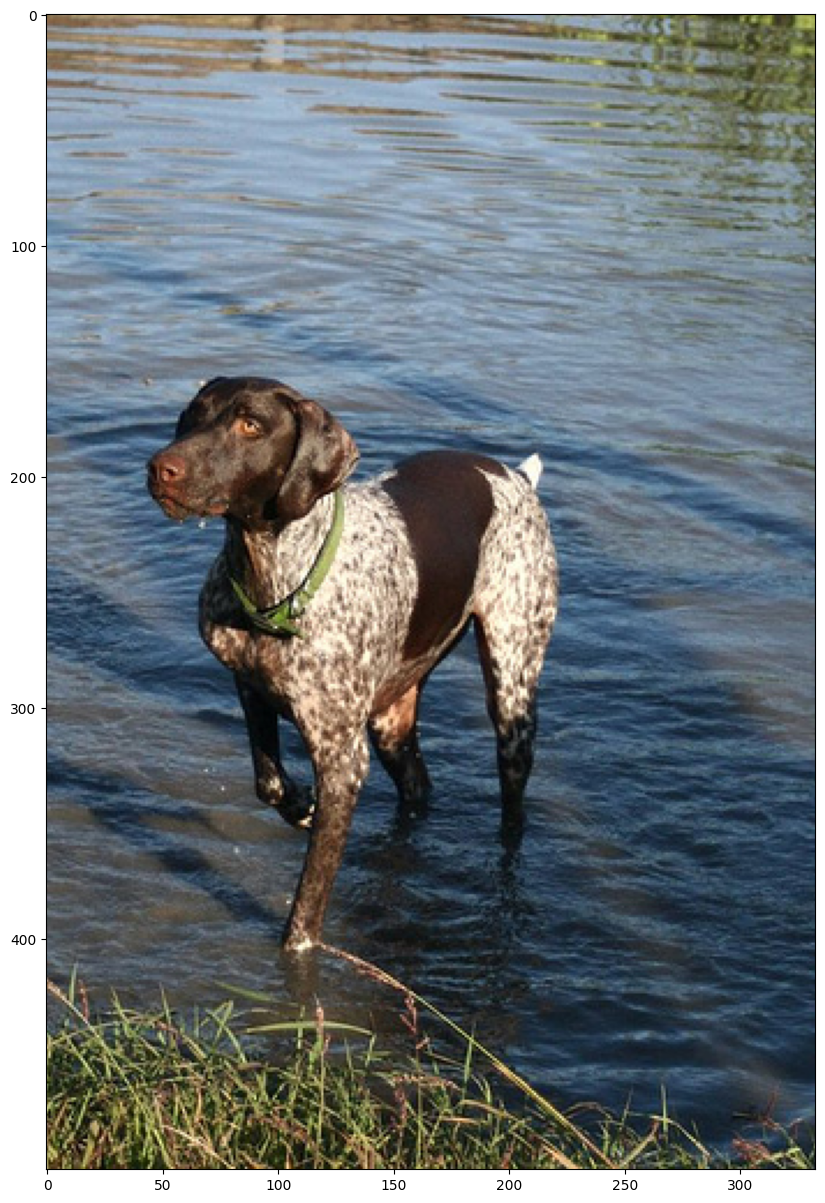

In [25]:
rnd = random.randint(0, len(image_names['pet']))
image_path = os.path.join(RAW_IMAGES_PATH, image_names['pet'][rnd])
image = Image.open(image_path)
plt.figure(figsize=(15,15))
plt.imshow(image)

# Florence2

Florence2 is an advanced computer vision model developed by Microsoft, designed to push the boundaries of visual recognition and understanding. As a successor to the original Florence model, Florence2 enhances its predecessor's capabilities by integrating state-of-the-art techniques in deep learning and neural networks. It is engineered to perform a wide range of computer vision tasks, such as object detection, image classification, and scene understanding, with higher accuracy and efficiency. Florence2 leverages vast amounts of training data and sophisticated architectures to deliver improved performance, making it a powerful tool for researchers and developers in the field of computer vision.

We will leverage the Florence2 model's object detection capabilities to generate our tags and bounding boxes.

In [26]:
model_id = 'microsoft/Florence-2-large'
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True, torch_dtype='auto').eval().cuda()
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:99: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


config.json:   0%|          | 0.00/2.44k [00:00<?, ?B/s]

configuration_florence2.py:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- configuration_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_florence2.py:   0%|          | 0.00/127k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- modeling_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


pytorch_model.bin:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- processing_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [27]:
def run_example(image ,task_prompt, text_input=None):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input

    inputs = processor(text=prompt, images=image, return_tensors="pt").to('cuda', torch.float16)

    generated_ids = model.generate(
      input_ids=inputs["input_ids"].cuda(),
      pixel_values=inputs["pixel_values"].cuda(),
      max_new_tokens=1024,
      early_stopping=False,
      do_sample=False,
      num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

    parsed_answer = processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=(image.width, image.height)
    )

    return parsed_answer[task_prompt]

In [28]:
def plot_bbox(image_and_results):
    image, data = image_and_results
   # Create a figure and axes
    plt.figure(figsize=(15, 15))
    ax = plt.gca()

    # Display the image
    ax.imshow(image)

    # Plot each bounding box
    for bbox, label in zip(data['bboxes'], data['labels']):

        # Unpack the bounding box coordinates
        x1, y1, x2, y2 = bbox
        # Create a Rectangle patch
        if label == 'person':
          color = 'red'
        else:
          color = 'blue'

        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor=color, facecolor='none')
        # Add the rectangle to the Axes
        ax.add_patch(rect)
        # Annotate the label
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor=color, alpha=0.5))

    # Remove the axis ticks and labels
    ax.axis('off')

    # Show the plot
    plt.show()

In [29]:
MIN_DIM = 32

def obj_size(bbox):
    w = (bbox[2] - bbox[0])
    h = (bbox[3] - bbox[1])
    return h >= MIN_DIM and w >= MIN_DIM

def filter_objects(results):

    # indices where the bbox dimentions are larger than some constant and labels are of the desired subjects
    indices = [ i for i in range(len(results['bboxes'])) if results['labels'][i] in subjects_words and obj_size(results['bboxes'][i]) ]

    filtered_results = {}
    filtered_results['bboxes'] = [results['bboxes'][i] for i in indices]

    # convert labels that describe person or pet to 'person' or 'pet'
    filtered_results['labels'] = ['person' if results['labels'][i] in person_words else 'pet'for i in indices ]
    return filtered_results

### Example

Let's use the Florence2 model to conduct object detection.

{'bboxes': [[316.25, 142.47500610351562, 393.25, 409.385009765625], [288.75, 107.21499633789062, 349.75, 354.44500732421875], [224.75, 130.58499145507812, 269.75, 312.2149963378906], [188.25, 124.84500122070312, 224.25, 276.9549865722656], [164.25, 114.18499755859375, 194.75, 254.40499877929688], [145.75, 111.7249984741211, 173.25, 238.8249969482422], [118.25, 119.51499938964844, 143.75, 222.01499938964844], [31.75, 323.69500732421875, 83.75, 351.9849853515625], [306.75, 334.3550109863281, 339.75, 354.44500732421875], [317.75, 374.125, 350.75, 390.5249938964844], [55.75, 317.9549865722656, 85.25, 334.7649841308594], [341.25, 393.3949890136719, 369.75, 409.385009765625], [289.25, 324.1050109863281, 316.75, 339.2749938964844], [238.25, 298.2749938964844, 260.75, 312.2149963378906], [225.75, 290.07501220703125, 244.75, 299.9150085449219], [170.75, 244.97499084472656, 191.25, 254.40499877929688], [196.25, 269.1650085449219, 218.75, 276.9549865722656], [123.75, 213.81500244140625, 142.25, 2

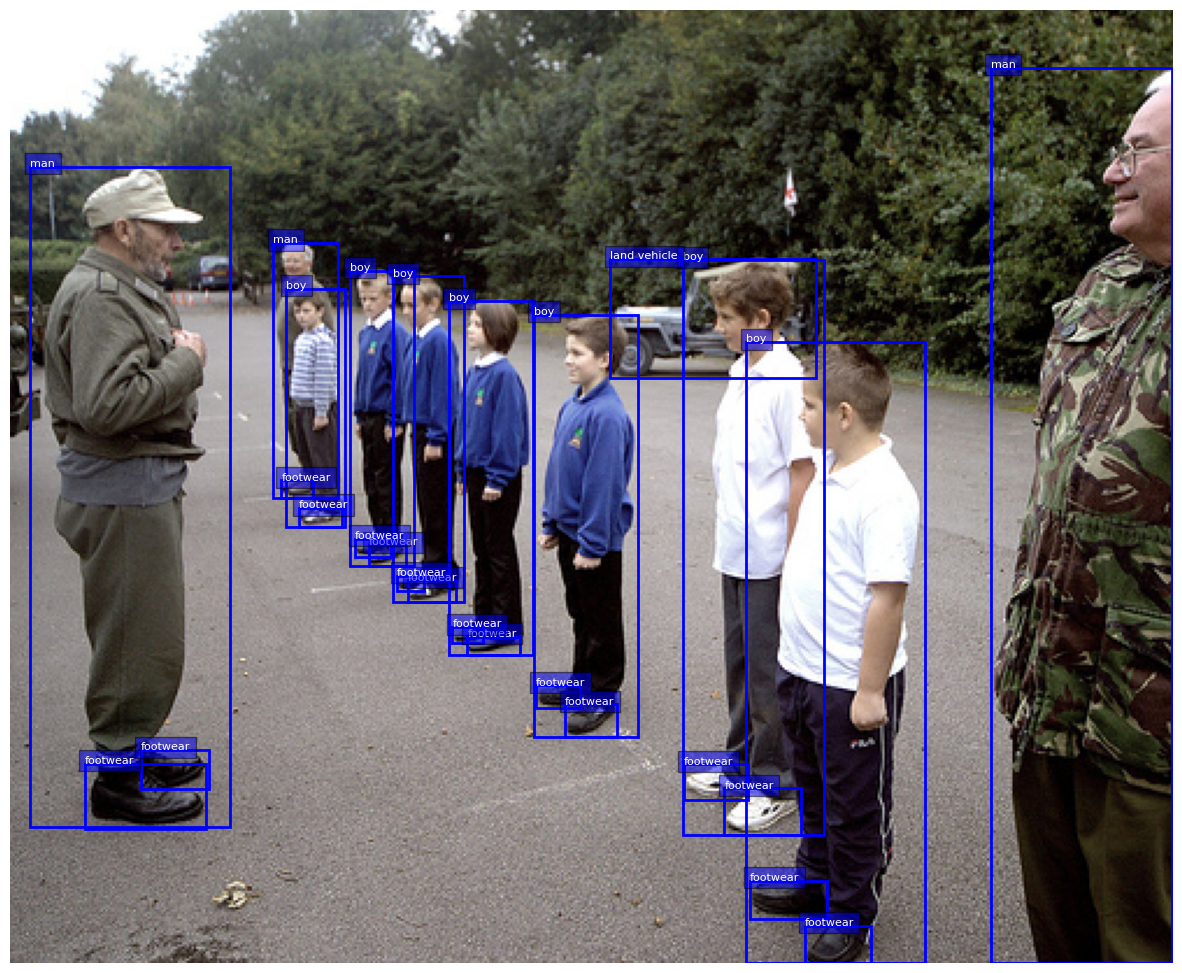

In [37]:
rnd = random.randint(0, len(image_names['person']))
image_path = os.path.join(RAW_IMAGES_PATH, image_names['person'][rnd])
image = Image.open(image_path)

task_prompt = '<OD>'
results = run_example(image, task_prompt)
print(results)


plot_bbox(image_and_results=(image, results))

We can observe that the model detects a wide variety of objects. Next, we'll filter the results to retain only the objects of interest for our specific requirements.

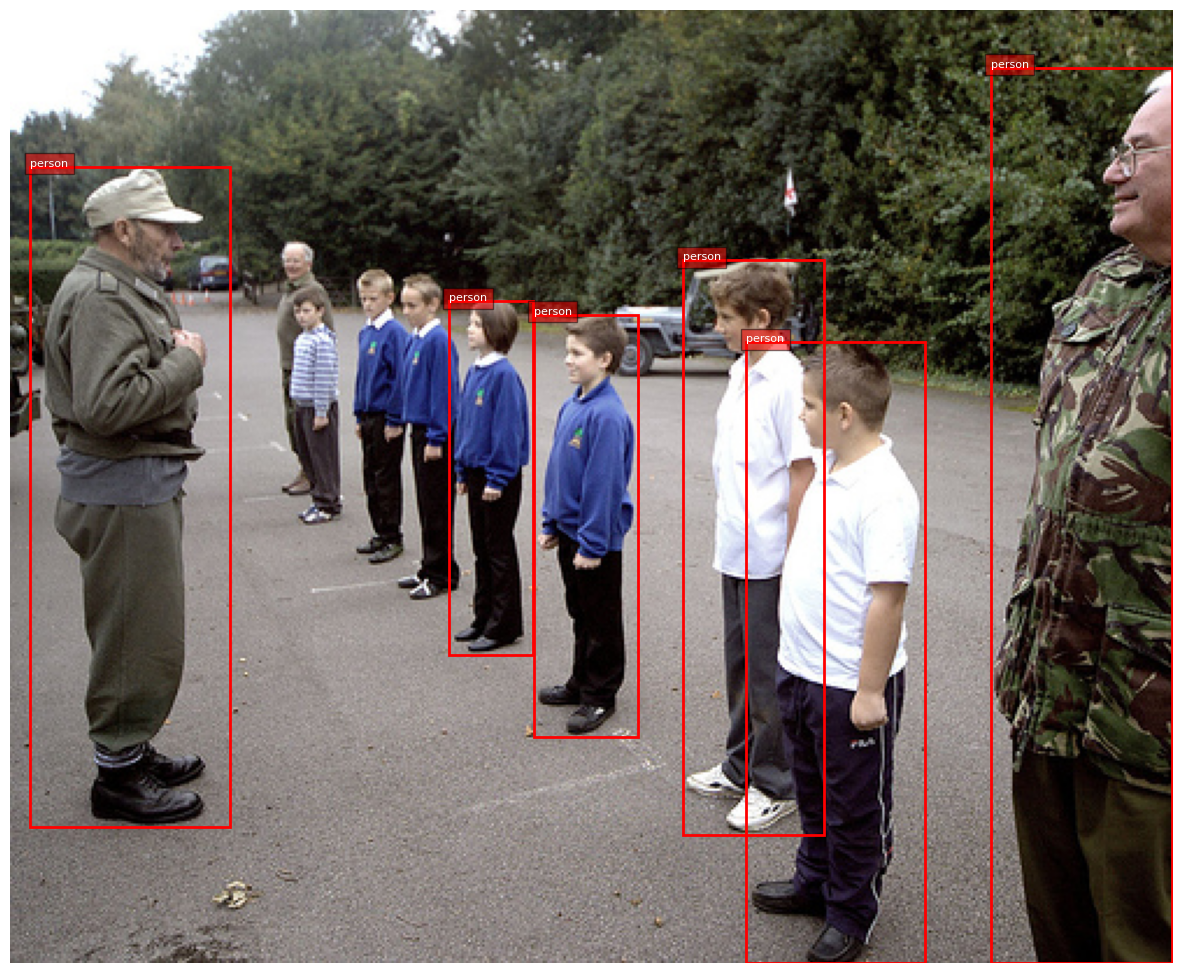

In [38]:
results = filter_objects(results)

plot_bbox(image_and_results=(image, results))

# Dataset class

Let's consolidate all of the aforementioned steps into a cohesive class implementation. This will streamline our process, encapsulate the functionality, and facilitate easier management and reuse of the code. By organizing these tasks into a structured class, we enhance the maintainability and scalability of our solution.

In [32]:
class PPDataset(Dataset):
  '''Person and Pet Dataset'''

  def __init__(self, data=None, directory_path=None, min_obj_size=32, class_size=800):
    '''
        Parameters:
          - data (List[str]): image names, example -(143012938409.jpg)
          - directory_path (str): path to directory conatining the images
          - min_obj_size (int): minimum object's bbox height and width in pixels (default = 32)
    '''
    super(PPDataset, self).__init__()

    self.class_size = class_size
    self.person_words = [ 'person', 'man', 'men' , 'male',
                'woman', 'women', 'female', 'kid',
                'boy', 'girl', 'guy', 'child', 'baby' ]

    self.pet_words = ['cat', 'kitten', 'dog', 'canine', 'puppy']

    self.subjects_words = self.person_words + self.pet_words

    if directory_path == None:
      directory_path = '/content/flickr-image-dataset/flickr30k_images/flickr30k_images/'

    self.directoty_path = directory_path

    self.task_prompt = '<OD>'
    self.min_obj_size = min_obj_size

    if data == None:
      # read the data from csv and filter the relevant images
      data = self.__read_data__()

    random.shuffle(data)
    self.xs = data

    self.dims = []
    self.ys = []
    for i in tqdm(range(len(self.xs))):
      dims, labels = self.__run_example__(i)
      self.dims.append(dims)
      self.ys.append(labels)


  def __getitem__(self, idx):
    # get the image
    image_path = os.path.join(self.directoty_path + self.xs[idx])
    image = Image.open(image_path)

    # get the bboxes and labels
    results = self.ys[idx]
    return image, results


  def __obj_size__(self, bbox):
    w = (bbox[2] - bbox[0])
    h = (bbox[3] - bbox[1])
    return h >= self.min_obj_size and w >= self.min_obj_size

  def __filter_objects__(self, results):
    # indices where the bbox dimentions are larger than some constant and labels are of the desired subjects
    indices = [ i for i in range(len(results['bboxes'])) if results['labels'][i] in self.subjects_words and self.__obj_size__(results['bboxes'][i]) ]

    filtered_results = {}
    filtered_results['bboxes'] = [results['bboxes'][i] for i in indices]

    # convert labels that describe person or pet to 'person' or 'pet'
    filtered_results['labels'] = ['person' if results['labels'][i] in self.person_words else 'pet'for i in indices ]

    return filtered_results

  def __run_example__(self, idx):

    image_path = os.path.join(self.directoty_path, self.xs[idx])
    image = Image.open(image_path)

    inputs = processor(text=self.task_prompt, images=image, return_tensors="pt").to('cuda', torch.float16)

    generated_ids = model.generate(
      input_ids=inputs["input_ids"].cuda(),
      pixel_values=inputs["pixel_values"].cuda(),
      max_new_tokens=1024,
      early_stopping=False,
      do_sample=False,
      num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

    parsed_answer = processor.post_process_generation(
        generated_text,
        task=self.task_prompt,
        image_size=(image.width, image.height)
    )

    return image.size ,self.__filter_objects__(parsed_answer[self.task_prompt])

  def train_val_split(self, train_split=0.8):
    '''
    split the dataset into train and validation sets
    parameters:
      train_split: the percentage of the dataset that will be used for training (default: 0.8)
    returns:
      train_xs, val_xs, train_ys, val_ys
    '''
    train_size = int(len(self.xs) * train_split)

    train_df = pd.DataFrame({'image_name': self.xs[:train_size], 'dimensions': self.dims[:train_size] })
    train_labels = self.ys[:train_size]

    val_df = pd.DataFrame({'image_name': self.xs[train_size:], 'dimensions': self.dims[train_size:]})
    val_labels = self.ys[train_size:]

    return train_df, val_df, train_labels, val_labels

  def __read_data__(self):
    # images info csv
    csv_path = '/content/flickr-image-dataset/flickr30k_images/results.csv'

    # read csv - parse it with the '| ' seperator
    image_info_df = pd.read_csv(csv_path, sep = r'\|\s*')
    image_info_df = image_info_df.dropna(axis=0)
    image_info_df = image_info_df.drop('comment_number', axis=1)
    image_info_df.reset_index(drop=True, inplace=True)

    image_names = {
    'person': set(),
    'pet': set()
    }

    # filter images of persons and pets
    for i in tqdm(range(len(image_info_df))):
      line = image_info_df.loc[i]
      comment = line.iloc[1]

      for word in comment.split():
        word = word.lower().strip()

        if word in self.person_words:
          image_names.get('person').add(line[0])
          break

        if word in self.pet_words:
          image_names.get('pet').add(line[0])
          break

    image_names = { k : list(image_names.get(k)) for k in image_names.keys() }
    return image_names['person'][:self.class_size] + image_names['pet'][:self.class_size]


  def __len__(self):
    return len(self.xs)

We will select 800 images for each class, allocating 640 images for training and 160 images for validation. This distribution ensures a robust training dataset while reserving a sufficient number of images for validating the model's performance.



In [41]:
size = 800
person_images = image_names['person'][:size]
pet_images = image_names['pet'][:size]
images = person_images + pet_images

dataset = PPDataset(data = images)

100%|██████████| 1600/1600 [18:03<00:00,  1.48it/s]


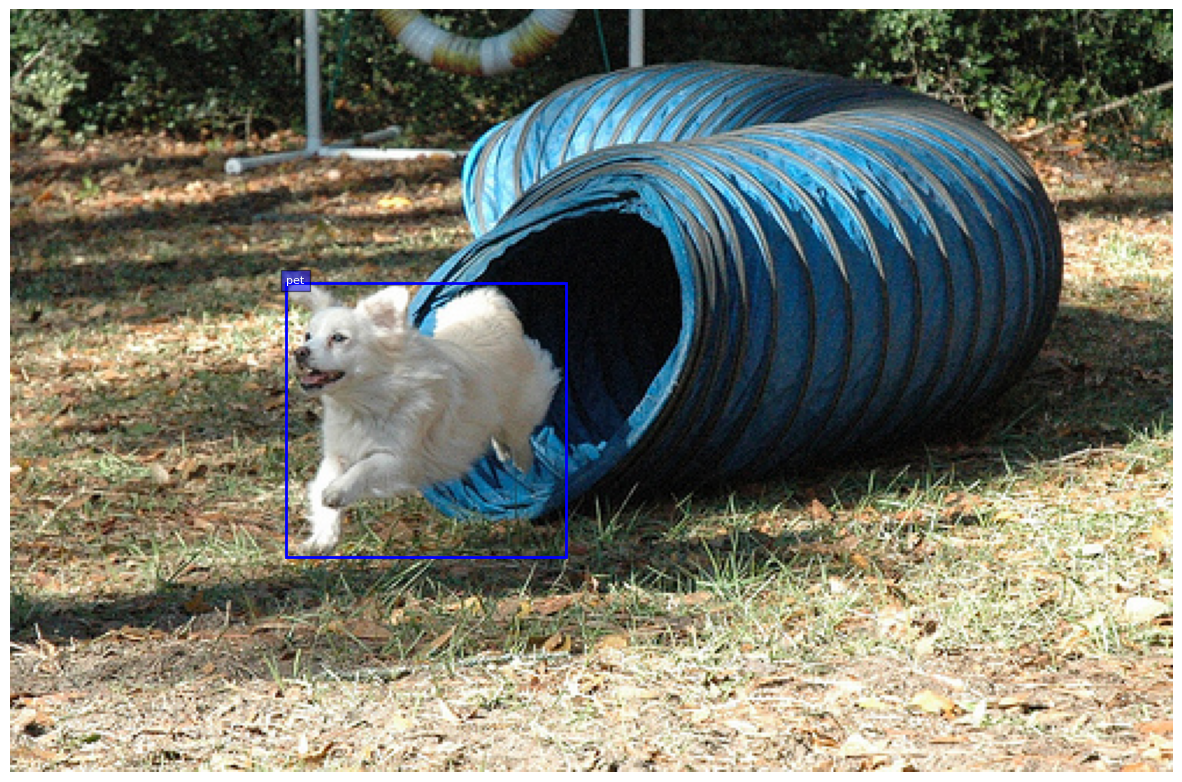

In [42]:
rnd = random.randint(0, len(dataset))
plot_bbox(dataset[rnd])

### Save Dataset to files


#### Helper Functions



In [43]:
# Convert to YOLO format
def normalize_bbox_yolo_format(image_dim ,bbox_dict):
  labels = bbox_dict['labels']
  bboxes = bbox_dict['bboxes']
  width, height = image_dim

  obj_strings = []

  for i in range(len(labels)):
    label = labels[i]
    bbox = bboxes[i]

    # Extract bbox center
    x_center = (bbox[0] + bbox[2]) / 2
    y_center = (bbox[1] + bbox[3]) / 2
    bbox_width = bbox[2] - bbox[0]
    bbox_height = bbox[3] - bbox[1]

    # Normalize values
    x_center = x_center / width
    y_center = y_center / height
    bbox_width = bbox_width / width
    bbox_height = bbox_height / height

    label_val = 0 if label == 'person' else 1
    obj_strings.append(f'{label_val} {x_center} {y_center} {bbox_width} {bbox_height}')

  return obj_strings

In [44]:
def save_image_and_labels_to_files(dir="/", image_name="", labels=[]):
  os.makedirs(dir, exist_ok=True)

  # copy image to directory
  src = os.path.join(IMAGES_PATH, image_name)
  image_dir_dst = os.path.join(dir, 'images')
  os.makedirs(image_dir_dst, exist_ok=True)
  dst = os.path.join(image_dir_dst, image_name)
  os.system(f'cp "{src}" "{dst}"')

  # save labels file
  labels_dir_dst = os.path.join(dir, 'labels')
  os.makedirs(labels_dir_dst, exist_ok=True)
  labels_string = '\n'.join(labels)
  dst = os.path.join(labels_dir_dst, image_name.replace('.jpg', '.txt'))
  with open(dst, 'w') as f:
    f.write(labels_string)

In [45]:
def save_data_in_yolo_format(data=None, path=""):
  for i in tqdm(range(len(data))):
    image_name = data.iloc[i]['image_name']
    dimensions = data.iloc[i]['dimensions']
    labels = data.iloc[i]['labels']

    norm_labels = normalize_bbox_yolo_format(dimensions, labels)
    save_image_and_labels_to_files(path, image_name, norm_labels)

In [46]:
def save_data_to_csv(path, data, file_name):
  os.makedirs(path, exist_ok=True)
  df = {'image_name': data['image_name'], 'dimensions': data['dimensions'], 'labels': data['labels']}
  df = pd.DataFrame(df)
  df.to_csv(os.path.join(path, file_name))


#### Saving

In [53]:
# move the selected images to our own directory
os.makedirs(IMAGES_PATH, exist_ok=True)
image_dir = '/content/flickr-image-dataset/flickr30k_images/flickr30k_images'

for image in dataset.xs:
    src = os.path.join(image_dir, image)
    dst = os.path.join(IMAGES_PATH, image)
    os.system(f'cp "{src}" "{dst}"')

In [54]:
# split data into train and val
train_xs, val_xs, train_ys, val_ys = dataset.train_val_split()


# save train set into a csv file
train_df = pd.DataFrame({'image_name': train_xs['image_name'], 'dimensions': train_xs['dimensions'] , 'labels': train_ys})
save_data_to_csv(TRAIN_PATH, train_df, 'train.csv')
# save val set into a csv file
val_df = pd.DataFrame({'image_name': val_xs['image_name'], 'dimensions': val_xs['dimensions'] , 'labels': val_ys})
save_data_to_csv(VAL_PATH, val_df, 'val.csv')


# Save trainset images and labels in yolo format
save_data_in_yolo_format(data=train_df, path=TRAIN_PATH)

# Save valset images and labels in yolo format
save_data_in_yolo_format(data=val_df, path=VAL_PATH)

100%|██████████| 320/320 [00:06<00:00, 50.84it/s]


## How TTA could be used to validate the annotations?

Test Time Augmentation (TTA) can be effectively used to verify the correctness of annotations in an object detection task. By applying various augmentations like rotations, flips, and scaling to test images during inference, the model’s predictions can be analyzed for consistency. After reversing these augmentations, the predictions should ideally align with the original annotations. Inconsistencies across different augmented versions of the same image can reveal potential issues, such as misaligned bounding boxes, missing annotations, or incorrect class labels. These discrepancies suggest where manual inspection and refinement are needed, leading to improved annotation accuracy and, consequently, better model performance.


## How ensembles can be used to check the correctness of the annotations of the train images

Ensemble methods can be employed to verify the correctness of annotations in the training images by leveraging multiple models to cross-check predictions. By training several models with varying architectures, hyperparameters, or subsets of data, you can generate predictions from each model. Aggregating these predictions through techniques such as majority voting or averaging helps form a consensus view. Comparing this aggregated output with the original annotations allows for the identification of discrepancies. Consistent predictions across multiple models suggest accurate annotations, while inconsistencies highlight potential issues that may require manual review. This approach enhances the reliability of the annotations and ensures a higher quality dataset for model training.


## Degrees of Freedom

In our project, we decided to include only objects with a bounding box height and width of at least 32 pixels each. This decision helps manage the degrees of freedom in our model by filtering out very small objects that might represent noise or irrelevant details, ensuring that we focus on more meaningful and substantial objects.

Additionally, we opted to select 800 images per class, which strikes a balance between having a sufficient amount of data for robust model training and maintaining the quality of the dataset. By combining these two decisions, we aim to reduce model complexity, minimize overfitting, and enhance overall performance by concentrating on relevant and representative images.